# Bayes estimation

In [1]:
import numpy as np
from numpy.linalg import inv, det

def bayes_estimation(X, mu_0, sigma_0):
    mu = np.array([np.mean(X[:,0]), np.mean(X[:,1])]).reshape(2,1)
    sigma = np.cov(X.T)
    mu_n = sigma_0.dot(inv(sigma_0 + (sigma / len(X)))).dot(mu) + (sigma.dot(inv(sigma_0 + (sigma / len(X)))).dot(mu_0))/len(X)   
    sigma_n = (sigma_0/len(X)).dot(inv(sigma_0 + (sigma / len(X)))).dot(sigma)
    return mu_n, sigma_n + sigma

In [2]:
from sklearn import cluster, datasets, mixture

X, y = datasets.make_moons(n_samples=500, noise=0.11)
X_class0 = [X[i] for i in range(len(X)) if y[i] == 0]
X_class1 = [X[i] for i in range(len(X)) if y[i] == 1]
X_class0 = np.array(X_class0)
X_class1 = np.array(X_class1)

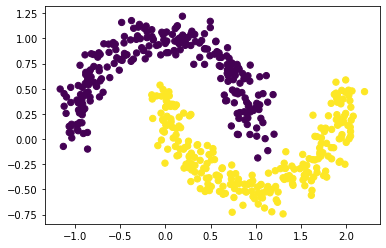

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
plt.show()

In [4]:
mu_0 = np.array([[0],[0]])
sigma_0 = np.array([[1,0],[0,1]])
mu_n_class0, sigma_n_class0 = bayes_estimation(X_class0, mu_0, sigma_0)
mu_n_class1, sigma_n_class1 = bayes_estimation(X_class1, mu_0, sigma_0)

In [5]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle, **kwargs))

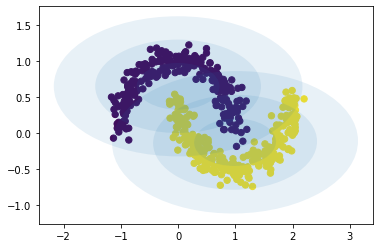

In [135]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
draw_ellipse(mu_n_class0, sigma_n_class0, alpha = 0.1)
draw_ellipse(mu_n_class1, sigma_n_class1, alpha = 0.1)

In [142]:
from scipy.stats import multivariate_normal

mu_n_class0.resize(2)
mu_n_class1.resize(2)
distribution_class_0 = multivariate_normal(mean=mu_n_class0, cov=sigma_n_class1)
distribution_class_1 = multivariate_normal(mean=mu_n_class1, cov=sigma_n_class1)
pdf_class_0 = distribution_class_0.pdf(X)
pdf_class_1 = distribution_class_1.pdf(X)

In [143]:
predicts = []
for i in range(len(pdf_class_0)):
    if pdf_class_0[i] > pdf_class_1[i]:
        predicts.append(0)
    else:
        predicts.append(1)

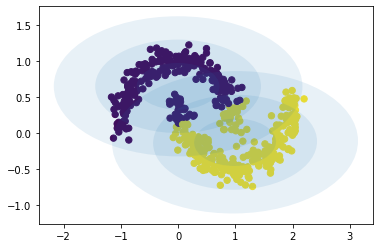

In [144]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=predicts, s=40, cmap='viridis')
draw_ellipse(mu_n_class0, sigma_n_class0, alpha = 0.1)
draw_ellipse(mu_n_class1, sigma_n_class1, alpha = 0.1)

# Gaussian Mixture Models

In [103]:
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)
        
    def n_parameters(self):
        n_features = np.array(self.mu).shape[1]
        cov_params = self.k * n_features * (n_features + 1) / 2.0
        mean_params = n_features * self.k
        return int(cov_params + mean_params + self.k - 1)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)
    
    def score_samples(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        return logsumexp(np.log(numerator) + np.log(denominator), axis=1)/2

    def score(self, X, y=None):
        return self.score_samples(X).mean()
    
    def bic(self, X):
        return -2 * self.score(X) * X.shape[0] + self.n_parameters() * np.log(X.shape[0])

    def aic(self, X):
        return -2 * self.score(X) * X.shape[0] + 2 * self.n_parameters()

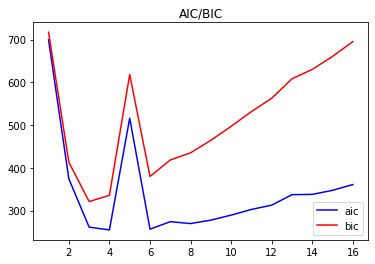

In [108]:
n_components = np.arange(1, 17)
BIC = np.zeros(n_components.shape)
AIC = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    gmm = GMM(k=n)
    gmm.fit(X_class0)
    AIC[i] = gmm.aic(X_class0)
    BIC[i] = gmm.bic(X_class0)

plt.plot(n_components, AIC, 'b', label='aic')
plt.plot(n_components, BIC, 'r', label='bic')
plt.title("AIC/BIC")
plt.legend()
plt.show()

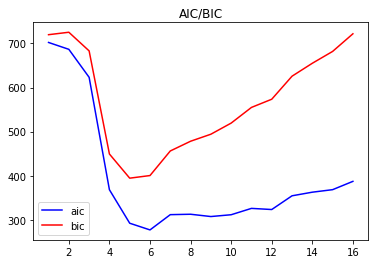

In [113]:
n_components = np.arange(1, 17)
BIC = np.zeros(n_components.shape)
AIC = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    gmm = GMM(k=n)
    gmm.fit(X_class1)
    AIC[i] = gmm.aic(X_class1)
    BIC[i] = gmm.bic(X_class1)

plt.plot(n_components, AIC, 'b', label='aic')
plt.plot(n_components, BIC, 'r', label='bic')
plt.title("AIC/BIC")
plt.legend()
plt.show()

In [115]:
def plot_data(mus, sigmas):
    ax = plt.gca()
    ax.scatter(X_class0[:, 0], X_class0[:, 1], c="blue", s=40, cmap='viridis')
    ax.scatter(X_class1[:, 0], X_class1[:, 1], c="red", s=40, cmap='viridis')
    for mu, sigma in zip(mus, sigmas):
        draw_ellipse(mu, sigma, alpha = 0.1)

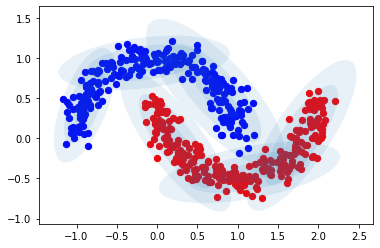

In [120]:
gmm_class0 = GMM(k=3)
gmm_class1 = GMM(k=3)
gmm_class0.fit(X_class0)
gmm_class1.fit(X_class1)

gmm_class0.mu.extend(gmm_class1.mu)
gmm_class0.sigma.extend(gmm_class1.sigma)

plot_data(gmm_class0.mu, gmm_class0.sigma)

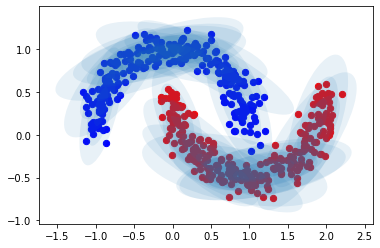

In [121]:
gmm_class0 = GMM(k=8)
gmm_class1 = GMM(k=8)
gmm_class0.fit(X_class0)
gmm_class1.fit(X_class1)

gmm_class0.mu.extend(gmm_class1.mu)
gmm_class0.sigma.extend(gmm_class1.sigma)

plot_data(gmm_class0.mu, gmm_class0.sigma)

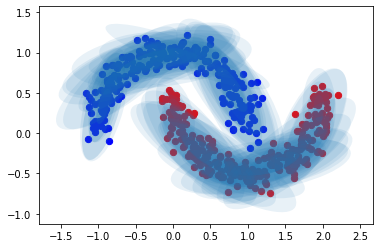

In [122]:
gmm_class0 = GMM(k=16)
gmm_class1 = GMM(k=16)
gmm_class0.fit(X_class0)
gmm_class1.fit(X_class1)

gmm_class0.mu.extend(gmm_class1.mu)
gmm_class0.sigma.extend(gmm_class1.sigma)

plot_data(gmm_class0.mu, gmm_class0.sigma)